In [11]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import operator
import networkx as nx
import plotly.graph_objects as go
import math
import matplotlib.patches as mpatches
from util.api import get_pkgs_usage_count

%matplotlib inline
plt.style.use('classic')

In [12]:
lts_list = ['0-7', '2-22', '3-22', '6-35', '7-24', '9-21', '11-22', '12-14', '12-26', '13-11', '13-19', '14-27', '15-3', '16-11']
df_list = []
df_by_category_list = []

for idx, lts in enumerate(lts_list):
    df = pd.read_pickle(f'../../data/lts-{lts}/lts-{lts}.df')
    df_list.append(df)
    
for idx, lts in enumerate(lts_list):
    df = pd.read_pickle(f'../../data/lts-{lts}/lts-{lts}-by-category.df')
    df_by_category_list.append(df)

# Research Questions (RQs)

- **RQ 1.** What packages are the most used? Which of them are outside from the Stackage selection?
- **RQ 2.** How many dependencies of packages are outside from the Stackage selection (in)directly?
- **RQ 3.** How frequently are the packages updated? 

Regarding monads, we analyze the evolution of dependencies of monad modules available in the mtl package:

- **RQ 4.** How has the use of monads evolved?
- **RQ 5.** Are there packages that stopped using monads?


## RQ 1. What packages are the most used? Which of them are outside from the Stackage selection?

Consideramos el ultimo snapshot publicado en Stackage, especificamente el LTS 16.11. Utilizamos el campo **Dependencies** del DataFrame para obtener el listado de las dependencias de cada paquete y construimos un diccionario de todos los paquetes y sus dependencias. Contamos la cantidad de veces que fue requerido cada uno de ellos para posteriormente ordenarlos ascendentemente y filtrar el top 25 de los mas utilizados. Luego, restamos el conjunto de todos los paquetes seleccionados del LTS 16.11 a la lista de los top 25 mas utilizados para obtener los paquetes que no formaron parte de la seleccion.

Descubrimientos:

- Pregunta 1    
    - El top 5 de los paquetes mas usados se mantuvo a lo largo de las 14 versiones LTS analizadas, estos son: base, bytestring, containers, text, and transformers
    - MTL, tiene un rol importante en lenguaje y mantiene el top 6 a lo largo de las versiones consideras
- Pregunta 2
    - Descubrimos que dentro de los 22 paquetes mas usados en las versiones [15-3 y 16-11] se ubica quickchek un libreria utilzia para hacer tests que no se encuentra en la seleccion realizada por stackage
    - Analizando en profundiad este caso, descrubirmos que existen una gran cantidad de paquetes que son utilizados pero no son parte de la seleccion -> (Esto da paso a la pregunta 2) 

In [13]:
top_25_pkgs = []
top_25_count = []
top_25_list = dict()

for idx, lts in enumerate(lts_list):
    top_25 = dict()
    packet_usage_count = get_pkgs_usage_count(df_list[idx])
    ordered_pkgs = sorted(packet_usage_count, key=packet_usage_count.get, reverse=True)[:25]

    for pkg in ordered_pkgs:
        top_25_pkgs.append(pkg)
        top_25_count.append(packet_usage_count[pkg])
        top_25[pkg] = packet_usage_count[pkg]
    
    top_25_list[lts] = top_25 

In [14]:
dic_lts = {'0-7':0,'6-35':3,'16-11':13}
dfs = [{},{},{}]
lista = []
for idx,lts in enumerate (dic_lts):
    indice = idx
    pkg = []
    deps = []
    df_lts1 = pd.DataFrame()
    top_pkg = list(top_25_list[lts].keys())[1:11]
    for idx, row in df_list[dic_lts[lts]].iterrows():
        for dependency in list(row['deps']):
            if dependency in top_pkg:
                pkg.append(row['package'])
                deps.append(dependency)
    df_lts1['package'] = pkg
    df_lts1['deps'] = deps

    list_cat = {}
    for pkg in top_pkg:  
        if pkg == 'text':
            list_cat[pkg] = (list(df_list[dic_lts[lts]][df_list[dic_lts[lts]]['package']==pkg]['categories'])[0][1])
        elif pkg == 'aeson':
            list_cat[pkg] = (list(df_list[dic_lts[lts]][df_list[dic_lts[lts]]['package']==pkg]['categories'])[0][1])
        else:
            list_cat[pkg] = (list(df_list[dic_lts[lts]][df_list[dic_lts[lts]]['package']==pkg]['categories'])[0][0])
    def get_coordinates_in_circle(n):
        thetas = [2*np.pi*(float(i)/n) for i in range(n)]
        returnlist = [(8*np.cos(theta),8*np.sin(theta)) for theta in thetas]
        return returnlist

    G = nx.from_pandas_edgelist(df_lts1, 'deps', 'package')

    degrees = dict(nx.degree(G))
    nx.set_node_attributes(G, name='degree', values=degrees)

    number_to_adjust_by = 3
    adjusted_node_size = dict([(node, degree*number_to_adjust_by) for node, degree in nx.degree(G)])
    nx.set_node_attributes(G, name='adjusted_node_size', values=adjusted_node_size)

    nx.set_node_attributes(G, name='categories', values=1)
    for node in G.nodes():
        if node in top_pkg:
            G.nodes[node]['categories'] = list_cat[node]
        else:
            G.nodes[node]['categories'] = 'others'

    labeldict = {}
    posdict = {}
    for node in G.nodes():  
        if node in top_pkg:
            labeldict[node] = node

    circular_positions = get_coordinates_in_circle(len(top_pkg))
    if indice == 0:
        lista = top_pkg
        fixed_nodes = top_pkg
    else:
        aux = []
        for i in range(len(lista)):
            if lista[i] == top_pkg[i]:
                aux.append(lista[i])
            else:
                count = 0
                for j in range(len(top_pkg)):
                    if lista[i] == top_pkg[j] and top_pkg[j]:
                        count+=1
                        aux.append(lista[i])
                if count == 0:
                    for x in range(len(top_pkg)):
                        if top_pkg[x] not in aux and top_pkg[x] not in lista and count != 1:
                            aux.append(top_pkg[x])     
                            count+=1
        fixed_nodes = aux

    pos = {}
    for i,p in enumerate(fixed_nodes):
        pos[p] = circular_positions[i]

    pos = nx.spring_layout(G,pos=pos, fixed=fixed_nodes,scale=2,k=0.3)
    
    node_color = []
    for node in G.nodes():
        if node == 'time':
            print(G.nodes[node]['categories'])
        if G.nodes[node]['categories'] == 'data':
            node_color.append('dodgerblue')
        elif G.nodes[node]['categories'] == 'data structures':
            node_color.append('darkturquoise')
        elif G.nodes[node]['categories'] == 'control':
            node_color.append('teal')
        elif G.nodes[node]['categories'] == 'web':
            node_color.append('lightseagreen')
        elif G.nodes[node]['categories'] == 'system':
            node_color.append('seagreen')
        else:
            node_color.append('green')
            
    blue_patch = mpatches.Patch(color='dodgerblue', label='data')        
    cyan_patch = mpatches.Patch(color='darkturquoise', label='data structures')        
    teal_patch = mpatches.Patch(color='teal', label='control')          
    tea1l_patch = mpatches.Patch(color='lightseagreen', label='web')      
    yellow_patch = mpatches.Patch(color='seagreen', label='system')        
    green_patch = mpatches.Patch(color='green', label='others')
    dfs[indice]['G']= G
    dfs[indice]['pos']= pos
    dfs[indice]['labeldict']= labeldict
    dfs[indice]['node_color']= node_color
    dfs[indice]['adjusted_node_size']= adjusted_node_size

system
system
time


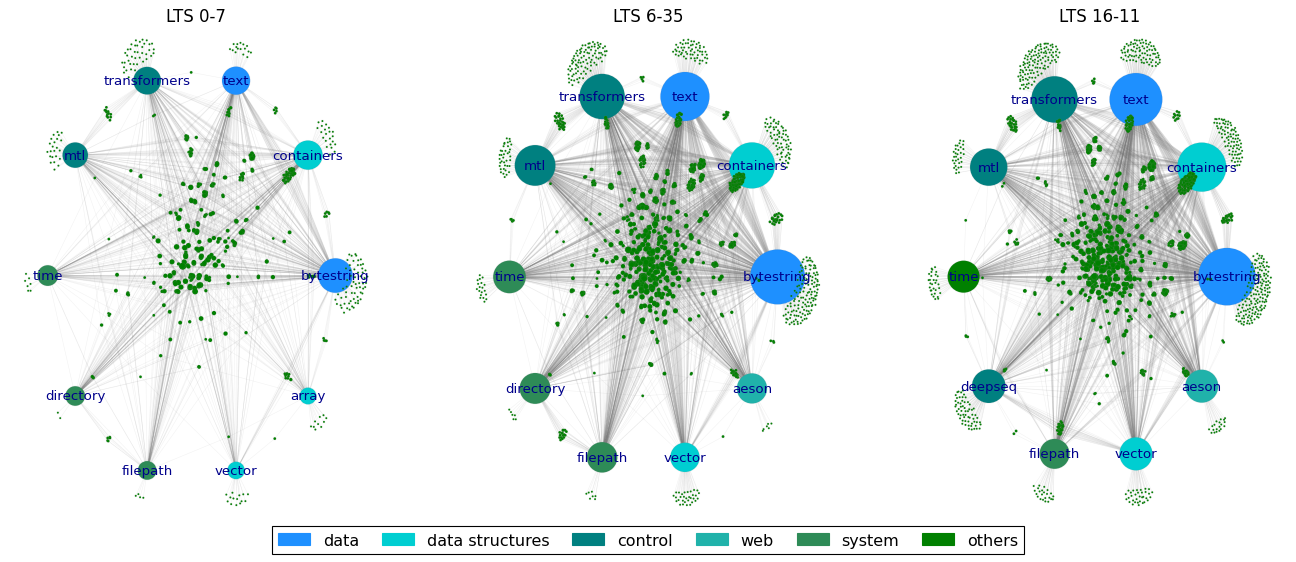

In [100]:
fig = plt.figure(figsize=(20,8))
color = (0.5, 0.5, 0.5, 0.1)

for i in range(len(dfs)): 
    plt.subplot(1,3,i+1)
    nx.draw(dfs[i]['G'],pos=dfs[i]['pos'],label=True, labels=dfs[i]['labeldict'],node_size=list(dfs[i]['adjusted_node_size'].values()),
                   edgecolors=color,width=0.5,edge_color=color,font_size=12,node_color = (dfs[i]['node_color']),font_color='darkblue')
    plt.title('LTS '+list(dic_lts.keys())[i], fontsize=15, y=0.98)  
    plt.subplots_adjust(left=0,right=0.8)
    plt.margins(x=0,y=0)
    if i == 1:       
        plt.legend(handles=[blue_patch,cyan_patch,teal_patch,tea1l_patch,yellow_patch,green_patch],bbox_to_anchor=(-0.5, -0.05, 2., .102), loc='lower left',
               ncol=6, mode="expand", borderaxespad=0.)
plt.savefig("../../graphs/rq1.pdf", format='pdf', bbox_inches='tight')


plt.show()

In [19]:
nx.set_node_attributes(G, name='pos', values=pos)
nodes = []
edges = []
for node in G.nodes():
    if G.nodes[node]['degree'] == 1:
        nodes.append(node)
for node,edge in G.edges():
    if edge in nodes:
        edges.append(node)
        
for idx,node in enumerate (nodes):
    x0,y0 = G.nodes[node]['pos']
    x1,y1 = G.nodes[edges[idx]]['pos']
    size = G.nodes[edges[idx]]['adjusted_node_size']